In [52]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.externals.six import StringIO 
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.metrics import make_scorer
import sklearn
from sklearn import decomposition

# XGBoost
import xgboost as xgb

# Pandas
import pandas as pd

# Numpy
import numpy as np
# Set random seed
np.random.seed(0)

# Plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import Image
import pydotplus

In [53]:
df = pd.read_csv('KeplerData.csv')
# remove canidates (2244 rows)
df = df[df['Exoplanet Archive Disposition'] != 'CANDIDATE']
target = 'Exoplanet Archive Disposition'
# can't include these columns because they are all null
invalids = ['Equilibrium Temperature Upper Uncertainty [K]', 'Equilibrium Temperature Lower Uncertainty [K]']
# these are all the features
features = list(set(df.columns[4:]) - set(invalids))
data = df[features + [target]]
# dropping any rows with na drops another 2538 rows
withoutna = data.dropna()
len(withoutna)

4782

In [54]:
train, test = sklearn.model_selection.train_test_split(withoutna)
y_train = train[target]
X_train = train[features]
y_test = test[target]
X_test = test[features]

In [55]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

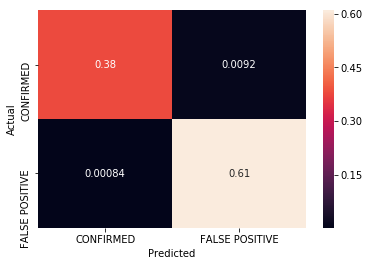

In [56]:
confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], normalize=True)
sns.heatmap(confusion, annot=True)

In [57]:
cv_scores_rf = cross_val_score(clf, X_test, y_test, cv=5)

print("Accuracy:\t\t", np.mean(cv_scores_rf))
print("Completeness:\t\t", sklearn.metrics.recall_score(y_test, y_pred, average='micro'))
print("Contamination:\t\t", 1 - sklearn.metrics.precision_score(y_test, y_pred, average='micro'))

Accuracy:		 0.9841073919107393
Completeness:		 0.9899665551839465
Contamination:		 0.010033444816053505


['Disposition Score',
 'Stellar Eclipse False Positive Flag',
 'Centroid Offset False Positive Flag',
 'Ephermeris Match Indicates Contamination False Positive Flag',
 'Maximum Multiple Event Statistic',
 'Number of Planets',
 'Planetary Radius [Earth radii]',
 'Not Transit-Like False Positive Flag',
 'Transit Signal-to-Noise',
 'Orbital Period [days]',
 'Impact Parameter']

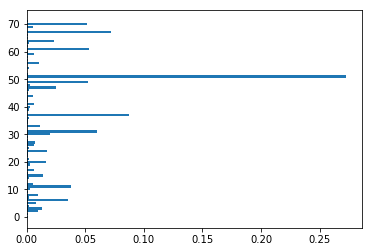

In [58]:
values = list(zip(features, clf.feature_importances_))
plt.barh(range(len(clf.feature_importances_)), [x[1] for x in values])
sortd = sorted(values, reverse = True, key= lambda x: x[1])[:20]
most_important = [s[0] for s in sortd]
# we dont want any features which have 'Uncertainty'
most_important = [x for x in most_important if 'Uncertainty' not in x]
most_important

Disposition Score                           \
                                          count      mean       std  min   
Exoplanet Archive Disposition                                              
CONFIRMED                                2285.0  0.962631  0.144378  0.0   
FALSE POSITIVE                           3976.0  0.014899  0.062409  0.0   

                                                       
                                 25%  50%  75%    max  
Exoplanet Archive Disposition                          
CONFIRMED                      0.993  1.0  1.0  1.000  
FALSE POSITIVE                 0.000  0.0  0.0  0.957

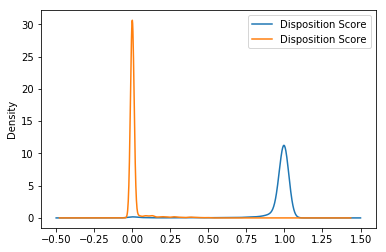

In [59]:
# here we look at the most important feature
fig, axs = plt.subplots(ncols=1)
data = df[['Disposition Score', target]]
data.groupby(target).plot(kind='kde', ax=axs)
data.groupby(target).describe()

Accuracy:		 0.9916317112619106
Completeness:		 0.9933110367892977
Contamination:		 0.006688963210702337


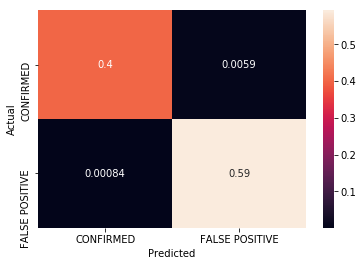

In [60]:
# Rerun using only the top 10 most important features
important = withoutna[most_important + [target]]
train, test = sklearn.model_selection.train_test_split(important)
y_train = train[target]
X_train = train[most_important]
y_test = test[target]
X_test = test[most_important]
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], normalize=True)
sns.heatmap(confusion, annot=True)
cv_scores_rf = cross_val_score(clf, X_test, y_test, cv=5)

print("Accuracy:\t\t", np.mean(cv_scores_rf))
print("Completeness:\t\t", sklearn.metrics.recall_score(y_test, y_pred, average='micro'))
print("Contamination:\t\t", 1 - sklearn.metrics.precision_score(y_test, y_pred, average='micro'))

KeyError: 'Exoplanet Archive Disposition'

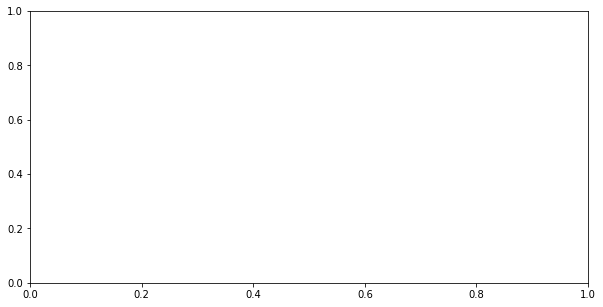

In [62]:
# iris = np.array(withoutna[most_important])
# species = target
# iris_colors = {'FALSE POSITIVE': 'g', 'CONFIRMED': 'r'}

# pca = decomposition.PCA(n_components=2)
# pca.fit(iris)
# iris_pca = pca.transform(iris)

# # projected coordinates
# fig, ax = plt.subplots(figsize = (10, 5))
# for specie in np.unique(species):
#     mask = (species == specie)
#     ax.scatter(iris_pca[mask][:, 0], iris_pca[mask][:, 1], label = specie, c = iris_colors[specie], alpha = 0.5)

# # loading vectors
# eviris = 2. * pca.components_
# for idx, var in enumerate(most_important[:-1]):
#     ax.plot([0, eviris[0, idx]], [0, eviris[1, idx]])
#     #ax.text(eviris[0, idx], eviris[1, idx], var)
# ax.set_xlabel("PCA 1")
# ax.set_ylabel("PCA 2")
# ax.legend();